# Import libraries for the project 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch import arch_model



# Load the data and rename colums

In [2]:
# Load the CSV
file_path = "gse_data.csv"
df = pd.read_csv(file_path)

# Clean up column names
df.columns = df.columns.str.strip()

# Rename columns
df = df.rename(columns={
    "Daily Date": "Date",
    "Closing Price - VWAP (GH¢)": "Adjusted Close"
})

# Keep only ACCESS
access_df = df[df["Share Code"] == "ACCESS"].copy()

# Convert Daily Date to datetime and set as index
access_df["Date"] =  pd.to_datetime(access_df['Date'], format='%d/%m/%Y', errors='coerce')
access_df.set_index("Date", inplace=True)

# Sort chronologically
access_df.sort_index(inplace=True)



In [3]:
access_df.head()

,Share Code,Year High (GH¢),Year Low (GH¢),Previous Closing Price - VWAP (GH¢),Opening Price (GH¢),Last Transaction Price (GH¢),Adjusted Close,Price Change (GH¢),Closing Bid Price (GH¢),Closing Offer Price (GH¢),Total Shares Traded,Total Value Traded (GH¢)
Date,,,,,,,,,,,,
2020-01-02,ACCESS,5.00,5.0,5.0,5.0,5.0,5.0,0.0,NaN,5.0,0.00,0.00
2020-01-03,ACCESS,5.00,5.0,5.0,5.0,5.0,5.0,0.0,NaN,5.0,0.00,0.00
2020-01-06,ACCESS,5.00,5.0,5.0,5.0,5.0,5.0,0.0,NaN,5.0,0.00,0.00
2020-01-08,ACCESS,5.00,5.0,5.0,5.0,5.0,5.0,0.0,NaN,5.0,0.00,0.00
2020-01-09,ACCESS,5.00,5.0,5.0,5.0,5.0,5.0,0.0,NaN,5.0,0.00,0.00


# Plot adjusted monthly closing prices for the data

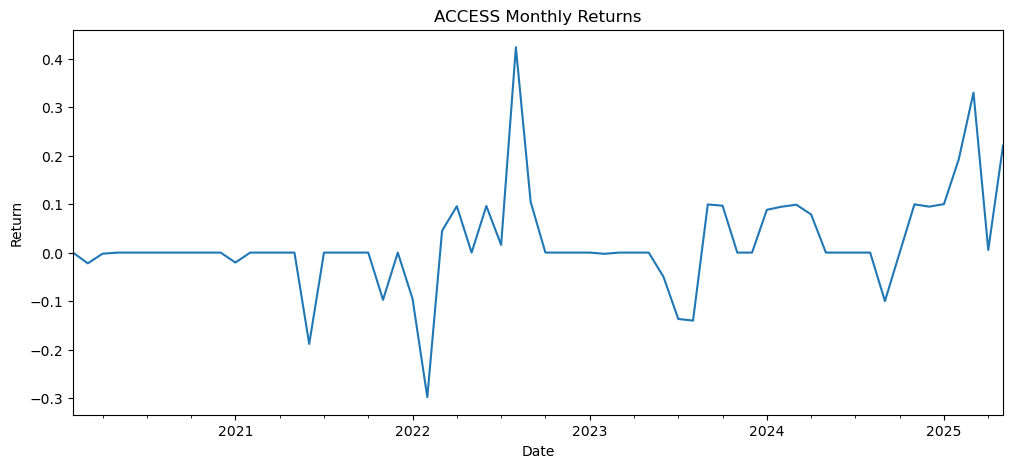

In [4]:
# Resample to month-end prices
monthly_prices = access_df["Adjusted Close"].resample("M").last()

# Compute simple percentage returns
monthly_returns = monthly_prices.pct_change().dropna()

plt.figure(figsize=(12,5))
monthly_returns.plot(title="ACCESS Monthly Returns")
plt.ylabel("Return")
plt.show()


# Detect outliers 

In [5]:
# Winsorize using IQR
Q1 = monthly_returns.quantile(0.25)
Q3 = monthly_returns.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

monthly_clean = np.clip(monthly_returns, lower_bound, upper_bound)
monthly_clean = monthly_clean[monthly_clean != 0]

# ADF Test
adf_result = adfuller(monthly_clean)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -2.88646444043294
p-value: 0.046944791586228295


# Fit GARCH ( 1, 1)  model

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         Adjusted Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -107.663
Distribution:                  Normal   AIC:                           223.326
Method:            Maximum Likelihood   BIC:                           229.062
                                        No. Observations:                   31
Date:                Fri, Aug 15 2025   Df Residuals:                       30
Time:                        18:34:24   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             5.4715      1.640      3.336  8.511e-04 [  2.257,  8.68

Text(0, 0.5, 'Volatility (%)')

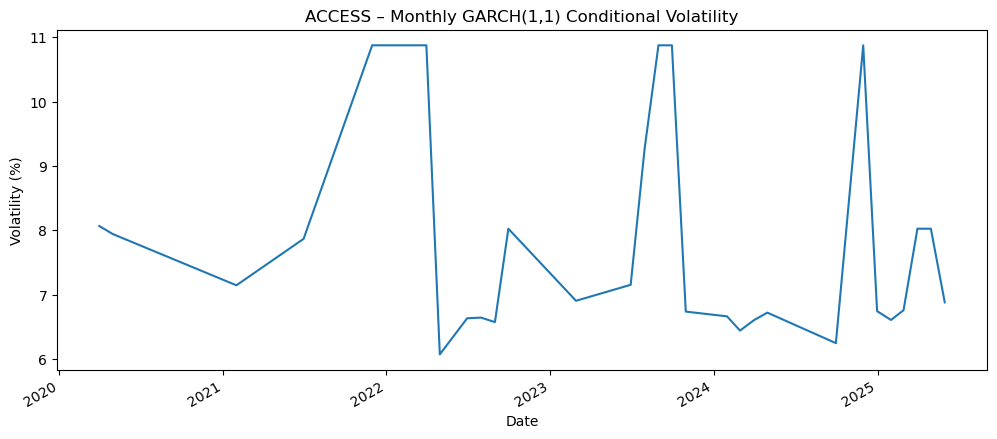

In [6]:
# Fit GARCH(1,1) on monthly percentage returns (scaled by 100)
model = arch_model(monthly_clean * 100, vol="GARCH", p=1, q=1, mean="Constant")
garch_res = model.fit(disp="off")

# Show results
print(garch_res.summary())

# Conditional (estimated) volatility
cond_vol = garch_res.conditional_volatility

# Plot
plt.figure(figsize=(12,5))
cond_vol.plot(title="ACCESS – Monthly GARCH(1,1) Conditional Volatility")
plt.ylabel("Volatility (%)")


# Fit ARCH(1) model

In [7]:
# Fit an ARCH(1) model (vol="ARCH", p=1)
arch_model_fit = arch_model(monthly_clean * 100, vol="ARCH", p=1, mean="Constant")
arch_res = arch_model_fit.fit(disp="off")

print(arch_res.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:         Adjusted Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -107.663
Distribution:                  Normal   AIC:                           221.326
Method:            Maximum Likelihood   BIC:                           225.628
                                        No. Observations:                   31
Date:                Fri, Aug 15 2025   Df Residuals:                       30
Time:                        18:34:24   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             5.4715      4.455      1.228      0.219 [ -3.261, 14.20

# Plot conditional volatility 

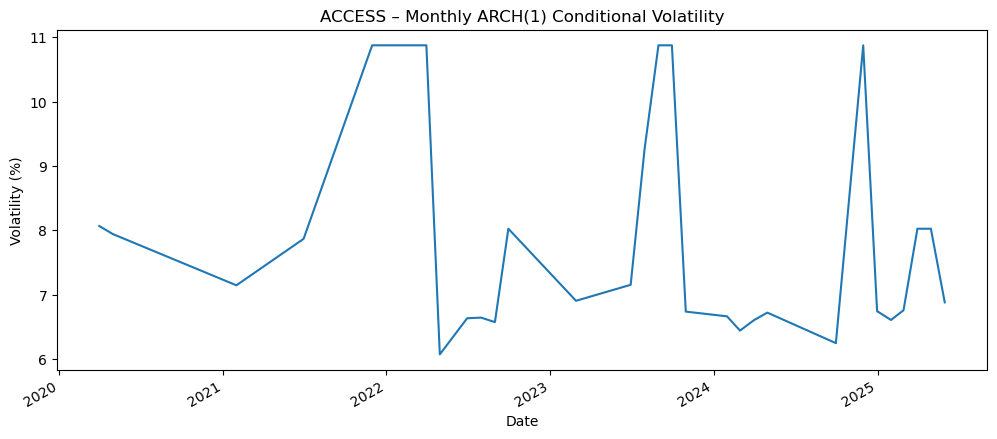

In [8]:
arch_vol = arch_res.conditional_volatility

plt.figure(figsize=(12,5))
arch_vol.plot(title="ACCESS – Monthly ARCH(1) Conditional Volatility")
plt.ylabel("Volatility (%)")
plt.show()